In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [2]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

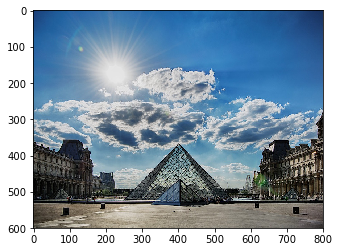

In [3]:
content_image = scipy.misc.imread("images/louvre.jpg")
imshow(content_image);

In [4]:
content_image.shape

(600, 800, 3)

In [5]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)))
    ### END CODE HERE ###
    
    return J_content

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


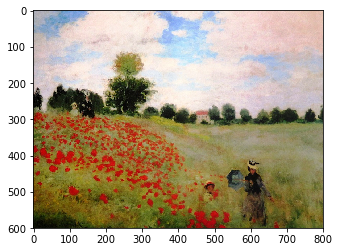

In [7]:
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image);

In [8]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
 
    GA = tf.matmul(A, tf.transpose(A))

    return GA

In [9]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = \n" + str(GA.eval()))

GA = 
[[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


In [10]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape = [-1, n_C]), perm = [1,0])
    a_G = tf.transpose(tf.reshape(a_G, shape = [-1, n_C]), perm = [1,0])

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1 / (4 * (np.square(n_C) * np.square(n_H * n_W)))) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
        
    return J_style_layer

In [11]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


In [12]:
STYLE_LAYERS = [
    ('conv1_1', 0.4),
    ('conv2_1', 0.5),
    ('conv3_1', 0.1),
    ('conv4_1', 0.0),
    ('conv5_1', 0.0)]

In [13]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer

    return J_style

In [14]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J

In [15]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [16]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [17]:
content_image = scipy.misc.imread("images/me400-2.jpg")
content_image = reshape_and_normalize_image(content_image)

In [18]:
style_image = scipy.misc.imread("images/gog400-2.jpg")
style_image = reshape_and_normalize_image(style_image)

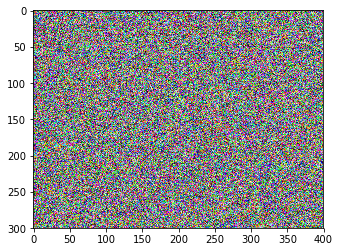

In [19]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [20]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [21]:
sess.run(model['input'].assign(content_image))
out = model['conv2_2']
a_C = sess.run(out)
a_G = out
J_content = compute_content_cost(a_C, a_G)

In [22]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)

In [23]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [24]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [ ]:
def model_nn(sess, input_image, num_iterations = 400):
    
    sess.run(tf.global_variables_initializer())

    sess.run(model['input'].assign(input_image))

    for i in range(num_iterations):

        sess.run(train_step)
        generated_image = sess.run(model['input'])

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image("output/" + str(i) + ".png", generated_image)
    
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 3.0283e+09
content cost = 4000.12
style cost = 7.57065e+07
Iteration 20 :
total cost = 4.53456e+08
content cost = 20469.2
style cost = 1.13313e+07
Iteration 40 :
total cost = 1.48441e+08
content cost = 16604.4
style cost = 3.70687e+06
Iteration 60 :
total cost = 6.75807e+07
content cost = 18068.5
style cost = 1.685e+06
Iteration 80 :
total cost = 3.36853e+07
content cost = 17733.2
style cost = 837699.0
Iteration 100 :
total cost = 2.08155e+07
content cost = 17543.8
style cost = 516003.0
Iteration 120 :
total cost = 1.52636e+07
content cost = 17512.9
style cost = 377212.0
Iteration 140 :
total cost = 1.21185e+07
content cost = 17523.1
style cost = 298583.0
Iteration 160 :
total cost = 1.00183e+07
content cost = 17530.7
style cost = 246076.0
Iteration 180 :
total cost = 8.46687e+06
content cost = 17546.2
style cost = 207285.0
Iteration 200 :
total cost = 7.26639e+06
content cost = 17572.1
style cost = 177267.0
Iteration 220 :
total cost = 6.31357e+06
content co